In [8]:
# requirements

# pip install pandas numpy pillow torch torchvision transformers scikit-learn timeout-decorator peft accelerate datasets bitsandbytes bert-score rouge-score rapidfuzz sentence-transformers evaluate

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import (
    ViltProcessor,
    ViltModel,

    PreTrainedModel,
    Trainer,
ViltForQuestionAnswering,
    TrainingArguments,
    ViltConfig
)
from transformers.modeling_outputs import SequenceClassifierOutput
from peft import get_peft_model, LoraConfig
from accelerate import Accelerator
import torch.nn as nn
from sklearn.metrics import accuracy_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


In [3]:
# Setup
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
accelerator = Accelerator()

### Dataset

In [9]:
BASE_DIR = "/kaggle/input/final-train-val"
IMAGE_BASE_PATH = "/kaggle/input/images"

train_df = pd.read_csv(f"{BASE_DIR}/train_datapoints.csv")
val_df = pd.read_csv(f"{BASE_DIR}/val_datapoints.csv")



for df in [train_df, val_df]: 
    # Fix backslashes to forward slashes
    df["full_image_path"] = df["full_image_path"].str.replace("\\\\", "/", regex=True)
    
    df["full_image_path"] = df["full_image_path"].apply(lambda x: os.path.join(IMAGE_BASE_PATH, x))
    df['answer'] = df['answer'].fillna('unknown')


In [6]:
# Load processor and base model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
vilt_base = ViltModel.from_pretrained("dandelin/vilt-b32-finetuned-vqa")


In [5]:
train_df

,image_id,full_image_path,question,answer
0,619aXYWDlfL,abo-images-small/images/small/82/8281b602.jpg,what color is the ring?,white
1,71oqXnBtfUL,abo-images-small/images/small/eb/ebb8f08b.jpg,what color is background?,pink
2,618rflVTnTL,abo-images-small/images/small/b9/b9c8a85a.jpg,how many stripes are visible?,three
3,61oFSxHBFLL,abo-images-small/images/small/68/6876f38e.jpg,what is the product?,case
4,717qOUqAkFL,abo-images-small/images/small/a9/a920ed25.jpg,what is the shape surrounding the image?,oval
...,...,...,...,...
55995,71Bz+4y4LRL,abo-images-small/images/small/7a/7a0a3699.jpg,what is the main color?,blue
55996,61PSTG1tCuL,abo-images-small/images/small/42/42ea42db.jpg,how many buttons are visible?,one
55997,61+OVTFVWRL,abo-images-small/images/small/03/03564753.jpg,what shape is the sensor?,square
55998,61eO4Ya4B+L,abo-images-small/images/small/59/5958556d.jpg,how many cameras are visible?,three


In [6]:
val_df

,image_id,full_image_path,question,answer
0,71uK-r+TRtL,abo-images-small/images/small/bc/bc859253.jpg,what is the shape?,rectangular
1,81qDgeDk8UL,abo-images-small/images/small/dc/dc90df81.jpg,"what is more prominent, the dark or light part?",dark
2,61JHYkmJsKL,abo-images-small/images/small/88/88d73c91.jpg,"which word is smaller, ""time"" or ""aayega""?",time
3,51Ftiw-ZG8L,abo-images-small/images/small/a9/a9ebb518.jpg,what time is shown?,8:08
4,61S5Jup3CJL,abo-images-small/images/small/d7/d7e9fd72.jpg,what color is the background?,pink
...,...,...,...,...
13995,71ouLd7oCrL,abo-images-small/images/small/f8/f83f60fe.jpg,are the letters capitalized?,yes
13996,71cFOSxSUyL,abo-images-small/images/small/4a/4ab940f6.jpg,how many mountains shown?,one
13997,81a+1NpiqyL,abo-images-small/images/small/ec/eca80999.jpg,what is the dominant color?,blue
13998,71QbwKb0hbL,abo-images-small/images/small/01/010c3e4d.jpg,what color is the dog's nose?,black


### Checking Image path

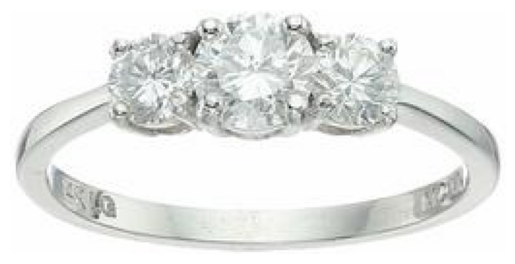

In [7]:

# === Display first image to verify path works ===
img_path = train_df['full_image_path'].iloc[0]
img = Image.open(img_path).convert("RGB")


plt.imshow(img)
plt.axis('off')  
plt.show()

In [14]:
# Creating the answer_to_idx mapping 
all_answers = list(set(train_df['answer'].tolist() + val_df['answer'].tolist()))
answer_to_idx = {a: i for i, a in enumerate(all_answers)}
num_labels = len(answer_to_idx)
print("Number of classes:", num_labels)

# Adjusting classification head to match your label count
model.config.num_labels = num_labels
model.classifier = torch.nn.Linear(model.classifier.in_features, num_labels)

### This Custom Dataset class loads image question answer pairs and encodes them with processo

In [66]:


# Dataset class
class VQADataset(Dataset):
    def __init__(self, df, processor, answer_to_idx):
        self.df = df
        self.processor = processor
        self.answer_to_idx = answer_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['full_image_path']
        try:
            image = Image.open(image_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224))  # fallback blank image

        # Aspect ratio preserved and padding
        image = ImageOps.pad(
            image,
            size=(384, 384),
            method=Image.BICUBIC,
            color=(0, 0, 0)
        )


        encoding = self.processor(
            text=row['question'],
            images=image,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=40
        )

        if "inputs_embeds" in encoding:
            del encoding["inputs_embeds"]
            
        label = torch.tensor(self.answer_to_idx.get(row["answer"], 0), dtype=torch.long)

        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = label
        return item

In [67]:

# Create datasets
train_dataset = VQADataset(train_df, processor, answer_to_idx)
val_dataset = VQADataset(val_df, processor, answer_to_idx)

## LoRa Config

In [ ]:
# LoRA config and apply
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)
model = get_peft_model(model, lora_config)
print("LoRA applied now")
model.print_trainable_parameters()

### Setting up training arguments and initialize Trainer for fine-tuning the VQA model

In [70]:
os.environ["WANDB_DISABLED"] = "true"

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=4e-5,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
    remove_unused_columns=False,
    disable_tqdm=False,
    save_strategy="epoch",
    eval_strategy="epoch",  # Evaluate on validation set each epoch
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

!pip install bert-score
from sklearn.metrics import accuracy_score
from bert_score import score as bert_score_fn

from sklearn.metrics import accuracy_score, f1_score
from nltk.corpus import wordnet

def is_synonym(pred, label):
    """Check if pred is a synonym of label using WordNet."""
    pred, label = pred.lower(), label.lower()
    synsets = wordnet.synsets(label)
    for s in synsets:
        for lemma in s.lemmas():
            if pred == lemma.name().lower():
                return True
    return False

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)

    acc = accuracy_score(labels, preds)

    # Convert label indices to text
    idx_to_answer = {v: k for k, v in answer_to_idx.items()}
    pred_texts = [idx_to_answer[p] for p in preds]
    label_texts = [idx_to_answer[l] for l in labels]

    # F1 Score (macro)
    f1 = f1_score(labels, preds, average="macro")

    # Synonym Accuracy
    synonym_correct = sum(
        pred == label or is_synonym(pred, label)
        for pred, label in zip(pred_texts, label_texts)
    )
    synonym_acc = synonym_correct / len(pred_texts)

    # BERTScore
    use_bert_score = True
    bert_precision = bert_recall = bert_f1 = 0.0
    if use_bert_score:
        P, R, F1 = bert_score_fn(pred_texts, label_texts, lang='en', verbose=True)
        bert_precision = P.mean().item()
        bert_recall = R.mean().item()
        bert_f1 = F1.mean().item()

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Synonym Accuracy: {synonym_acc:.4f}")
    if use_bert_score:
        print(f"BERT Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, F1: {bert_f1:.4f}")

    return {
        "accuracy": acc,
        "f1": f1,
        "synonym_accuracy": synonym_acc,
        "bert_precision": bert_precision,
        "bert_recall": bert_recall,
        "bert_f1": bert_f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # val dataset for evaluation during training
    tokenizer=processor,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/tmp/ipykernel_116/2269512470.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [71]:
sample = train_dataset[0]
print(sample.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [72]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Synonym Accuracy,Bert Precision,Bert Recall,Bert F1
1,3.367900,3.134512,0.354608,0.012380,0.364865,0.989793,0.983222,0.986271
2,2.562500,2.699766,0.435204,0.023263,0.445045,0.989205,0.983988,0.986363
3,3.001500,2.467088,0.468884,0.035846,0.479764,0.989041,0.984761,0.986665
4,2.110300,2.321940,0.496535,0.051445,0.507831,0.989612,0.985919,0.987550
5,2.379400,2.231707,0.516355,0.059584,0.528898,0.989534,0.986247,0.987677
6,1.927200,2.175604,0.518087,0.065746,0.530977,0.989184,0.986317,0.987539
7,1.958800,2.133673,0.531809,0.073568,0.544421,0.990032,0.986836,0.988236
8,1.511700,2.100969,0.540402,0.082354,0.553361,0.989456,0.986915,0.987978
9,1.739100,2.082793,0.543590,0.085136,0.557519,0.989819,0.987094,0.988257
10,1.997200,2.074575,0.544629,0.084120,0.557866,0.989838,0.987078,0.988257


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5440.83 sentences/sec
Accuracy: 0.3546
F1 Score (macro): 0.0124
Synonym Accuracy: 0.3649
BERT Precision: 0.9898, Recall: 0.9832, F1: 0.9863


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.68 seconds, 5378.63 sentences/sec
Accuracy: 0.4352
F1 Score (macro): 0.0233
Synonym Accuracy: 0.4450
BERT Precision: 0.9892, Recall: 0.9840, F1: 0.9864


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.68 seconds, 5378.89 sentences/sec
Accuracy: 0.4689
F1 Score (macro): 0.0358
Synonym Accuracy: 0.4798
BERT Precision: 0.9890, Recall: 0.9848, F1: 0.9867


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.69 seconds, 5370.81 sentences/sec
Accuracy: 0.4965
F1 Score (macro): 0.0514
Synonym Accuracy: 0.5078
BERT Precision: 0.9896, Recall: 0.9859, F1: 0.9875


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.66 seconds, 5416.78 sentences/sec
Accuracy: 0.5164
F1 Score (macro): 0.0596
Synonym Accuracy: 0.5289
BERT Precision: 0.9895, Recall: 0.9862, F1: 0.9877


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.71 seconds, 5322.58 sentences/sec
Accuracy: 0.5181
F1 Score (macro): 0.0657
Synonym Accuracy: 0.5310
BERT Precision: 0.9892, Recall: 0.9863, F1: 0.9875


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.66 seconds, 5421.01 sentences/sec
Accuracy: 0.5318
F1 Score (macro): 0.0736
Synonym Accuracy: 0.5444
BERT Precision: 0.9900, Recall: 0.9868, F1: 0.9882


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.69 seconds, 5373.24 sentences/sec
Accuracy: 0.5404
F1 Score (macro): 0.0824
Synonym Accuracy: 0.5534
BERT Precision: 0.9895, Recall: 0.9869, F1: 0.9880


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5447.76 sentences/sec
Accuracy: 0.5436
F1 Score (macro): 0.0851
Synonym Accuracy: 0.5575
BERT Precision: 0.9898, Recall: 0.9871, F1: 0.9883


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/17 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/226 [00:00<?, ?it/s]

done in 2.65 seconds, 5440.85 sentences/sec
Accuracy: 0.5446
F1 Score (macro): 0.0841
Synonym Accuracy: 0.5579
BERT Precision: 0.9898, Recall: 0.9871, F1: 0.9883


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in  - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=72170, training_loss=2.2781769370081286, metrics={'train_runtime': 19160.7216, 'train_samples_per_second': 30.132, 'train_steps_per_second': 3.767, 'total_flos': 1.27974348356736e+16, 'train_loss': 2.2781769370081286, 'epoch': 10.0})

In [77]:
trainer.save_model("./finee_tuned_final-VILT-_vqa_lora")
print("Model saved to './finee_tuned_VILT_vqa_lora'")

Model saved to './finee_tuned_VILT_vqa_lora'


In [78]:

# Zip results 
os.system("zip -r viltt_final_model.zip ./results")
# Provide a clickable download link
display(FileLink("viltt_final_model.zip"))

updating: results/ (stored 0%)
updating: results/checkpoint-72170/ (stored 0%)
updating: results/checkpoint-72170/training_args.bin (deflated 52%)
updating: results/checkpoint-72170/scaler.pt (deflated 60%)
updating: results/checkpoint-72170/tokenizer_config.json (deflated 75%)
updating: results/checkpoint-72170/preprocessor_config.json (deflated 51%)
updating: results/checkpoint-72170/rng_state.pth (deflated 25%)
updating: results/checkpoint-72170/README.md (deflated 66%)
updating: results/checkpoint-72170/tokenizer.json (deflated 71%)
updating: results/checkpoint-72170/adapter_model.safetensors (deflated 7%)
updating: results/checkpoint-72170/special_tokens_map.json (deflated 80%)
updating: results/checkpoint-72170/scheduler.pt (deflated 55%)
updating: results/checkpoint-72170/adapter_config.json (deflated 54%)
updating: results/checkpoint-72170/vocab.txt (deflated 53%)
updating: results/checkpoint-72170/optimizer.pt (deflated 7%)
updating: results/checkpoint-72170/trainer_state.json

0

In [79]:
from IPython.display import FileLink

# After zipping
os.system("zip -r viltt_final_model.zip ./results")

# Provide a clickable download link
display(FileLink("viltt_final_model.zip"))


updating: results/ (stored 0%)
updating: results/checkpoint-72170/ (stored 0%)
updating: results/checkpoint-72170/training_args.bin (deflated 52%)
updating: results/checkpoint-72170/scaler.pt (deflated 60%)
updating: results/checkpoint-72170/tokenizer_config.json (deflated 75%)
updating: results/checkpoint-72170/preprocessor_config.json (deflated 51%)
updating: results/checkpoint-72170/rng_state.pth (deflated 25%)
updating: results/checkpoint-72170/README.md (deflated 66%)
updating: results/checkpoint-72170/tokenizer.json (deflated 71%)
updating: results/checkpoint-72170/adapter_model.safetensors (deflated 7%)
updating: results/checkpoint-72170/special_tokens_map.json (deflated 80%)
updating: results/checkpoint-72170/scheduler.pt (deflated 55%)
updating: results/checkpoint-72170/adapter_config.json (deflated 54%)
updating: results/checkpoint-72170/vocab.txt (deflated 53%)
updating: results/checkpoint-72170/optimizer.pt (deflated 7%)
updating: results/checkpoint-72170/trainer_state.json

/kaggle/working/viltt_final_model.zip

In [86]:


model_path = "/kaggle/working/finee_tuned_final-VILT-_vqa_lora" 
print("Files in model directory:")
print(os.listdir(model_path))


Files in model directory:
['training_args.bin', 'tokenizer_config.json', 'preprocessor_config.json', 'README.md', 'tokenizer.json', 'adapter_model.safetensors', 'special_tokens_map.json', 'adapter_config.json', 'vocab.txt']
